## Завдання

In [ ]:
    Ви - аналітик у продуктовій ІТ-компанії. На платформі стався технічний збій, який може мати вплив на виручку.
Збій стався 16 травня 2024 і його наслідки тривають досі.
    Вам потрібно оцінити потенційне зменшення виручки внаслідок збою. При цьому варто врахувати, що на
виручку можуть впливати багато інших факторів. Серед них:
        • впродовж цього періоду змінювалася структура користувачів та рекламні бюджети;
        • з 15 березня проводився великий спліт-тест;
        • в кінці березня зменшилася команда підтримки;
        • на початку квітня змінилися логіки роботи з листами;
        • у середині квітня відбувся реліз нової OS;
        • у виручки може бути циклічність.

    Потрібно знайти якомога більше релевантних факторів, оцінити і врахувати їх вплив. Після цього визначити, на
скільки зменшив виручку саме технічний збій 16 травня. А також визначити цільову аудиторію.m

## Початок роботи

In [210]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, bootstrap


import pycaret.regression as reg

import statsmodels.api as sm

In [2]:
df = pd.read_csv("C:\\Users\\ASUS-X515EP\\Downloads\\Telegram Desktop\\analytics_test_case.csv")
# Рахую ARPU
df['ARPU'] = df['revenue'] / df['users']
df.head()

,date,users,revenue,split_group,gender,os_version,age_group,country_group,ARPU
0,2024-03-01,1077,3770.39,NaN,male,1,45+,USA,3.500826
1,2024-03-01,744,1060.22,NaN,male,1,45+,Tier_1,1.425027
2,2024-03-01,657,979.49,NaN,male,1,45+,Other,1.490852
3,2024-03-01,251,548.77,NaN,male,1,45-,USA,2.186335
4,2024-03-01,143,604.85,NaN,male,1,45-,Tier_1,4.229720


## Візуалізація впливу факторів

### Графіки

In [42]:
# Function to vis events
def viz(y, hue, title):
    if y == 'ARPU':
        sns.set_style('dark')
        fig, ax = plt.subplots(figsize=(18.5, 5))
        sns.lineplot(
            data=df,
            x='date',
            y=y,
            hue=hue,
            estimator='mean',
            ax=ax,
            ci=None)
        plt.xticks(rotation=90)
        ax.axvline(x='2024-03-15', color='r', label='A/B', linestyle='--', linewidth=2)
        ax.axvline(x='2024-04-01', color='b', label='List Change', linestyle='--', linewidth=2)
        ax.axvline(x='2024-04-15', color='y', label='New OS', linestyle='--', linewidth=2)
        ax.axvline(x='2024-04-29', color='g', label='Support Change', linestyle='--', linewidth=2)
        ax.axvline(x='2024-05-16', color='m', label='Anomaly', linestyle='--', linewidth=3)
        plt.title(title)
        plt.legend()
        plt.show()
    else:
        sns.set_style('dark')
        fig, ax = plt.subplots(figsize=(18.5, 5))
        sns.lineplot(
            data=df,
            x='date',
            y=y,
            hue=hue,
            estimator='sum',
            ax=ax,
            ci=None)
        plt.xticks(rotation=90)
        ax.axvline(x='2024-03-15', color='r', label='A/B', linestyle='--', linewidth=2)
        ax.axvline(x='2024-04-01', color='b', label='List Change', linestyle='--', linewidth=2)
        ax.axvline(x='2024-04-15', color='y', label='New OS', linestyle='--', linewidth=2)
        ax.axvline(x='2024-04-29', color='g', label='Support Change', linestyle='--', linewidth=2)
        ax.axvline(x='2024-05-16', color='m', label='Anomaly', linestyle='--', linewidth=3)
        plt.title(title)
        plt.legend()
        plt.show()

### Overall 

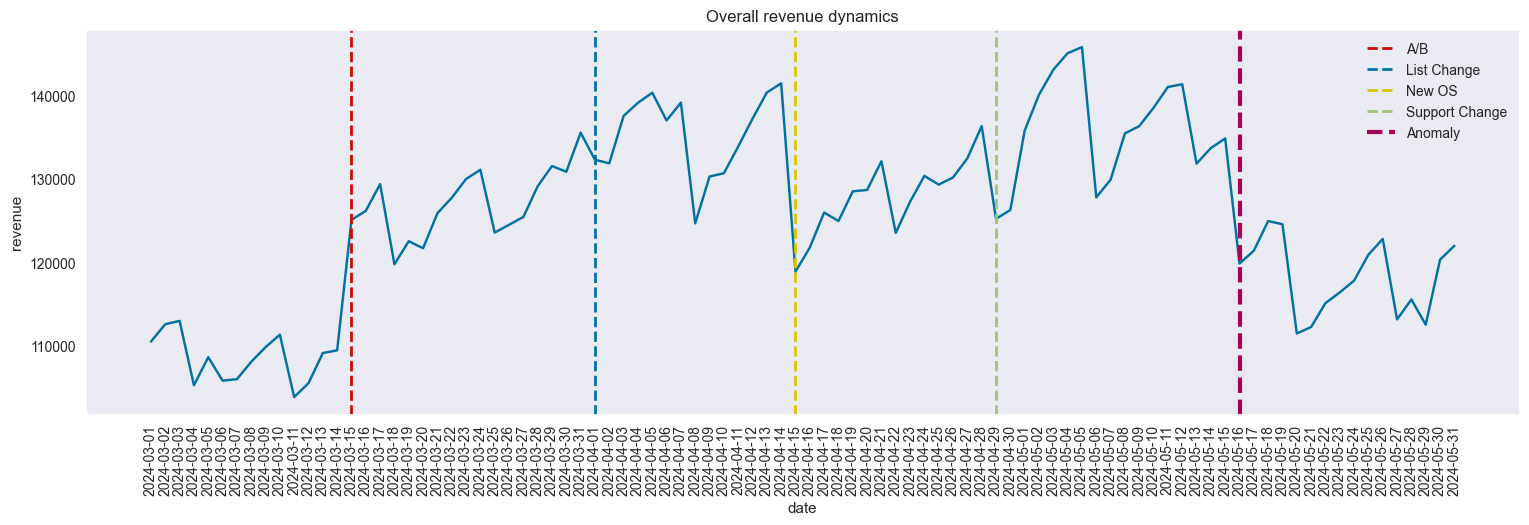

In [43]:
viz('revenue', None, 'Overall revenue dynamics')

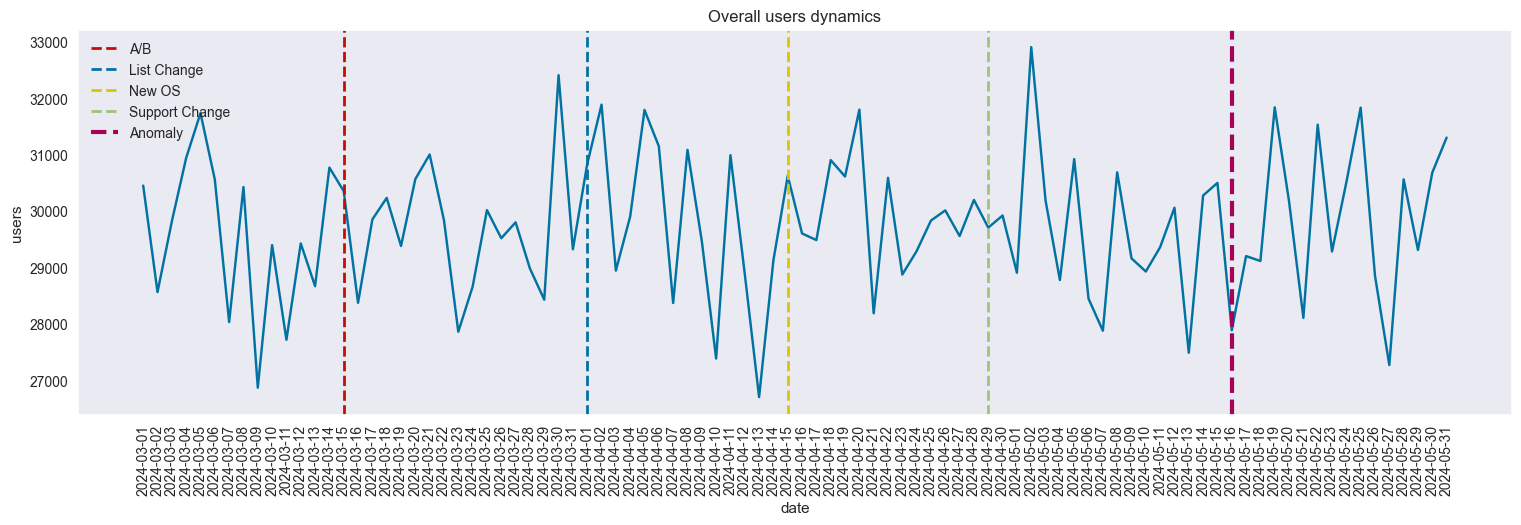

In [44]:
viz('users', None, 'Overall users dynamics')

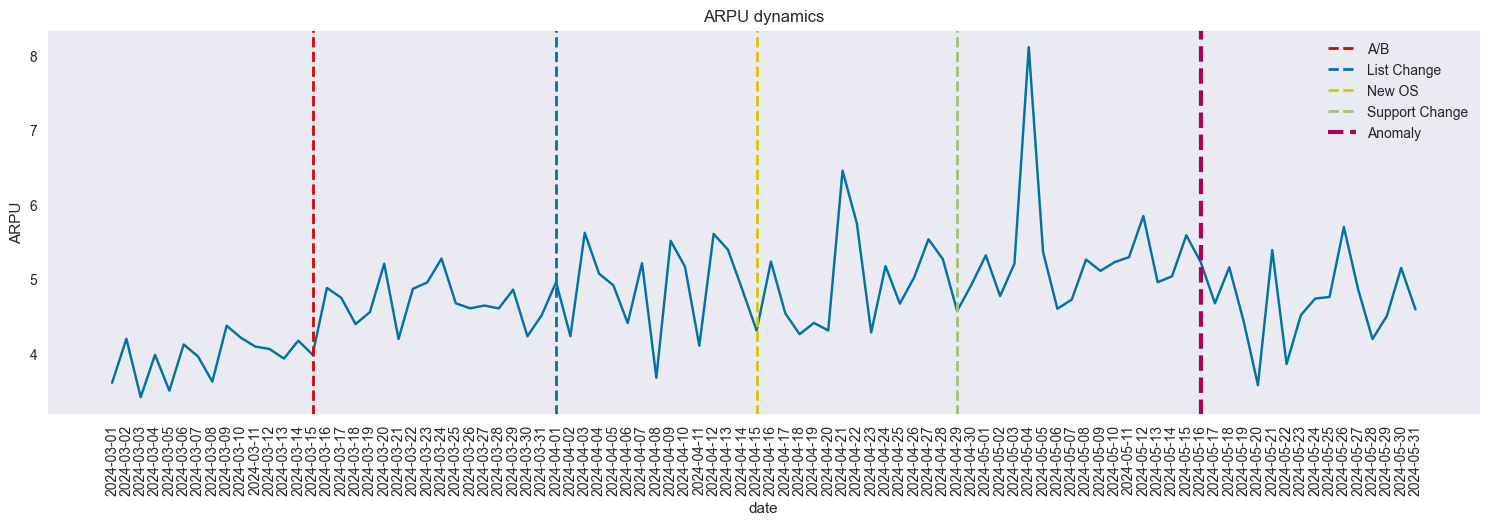

In [46]:
viz('ARPU', None, 'ARPU dynamics')

### Split test

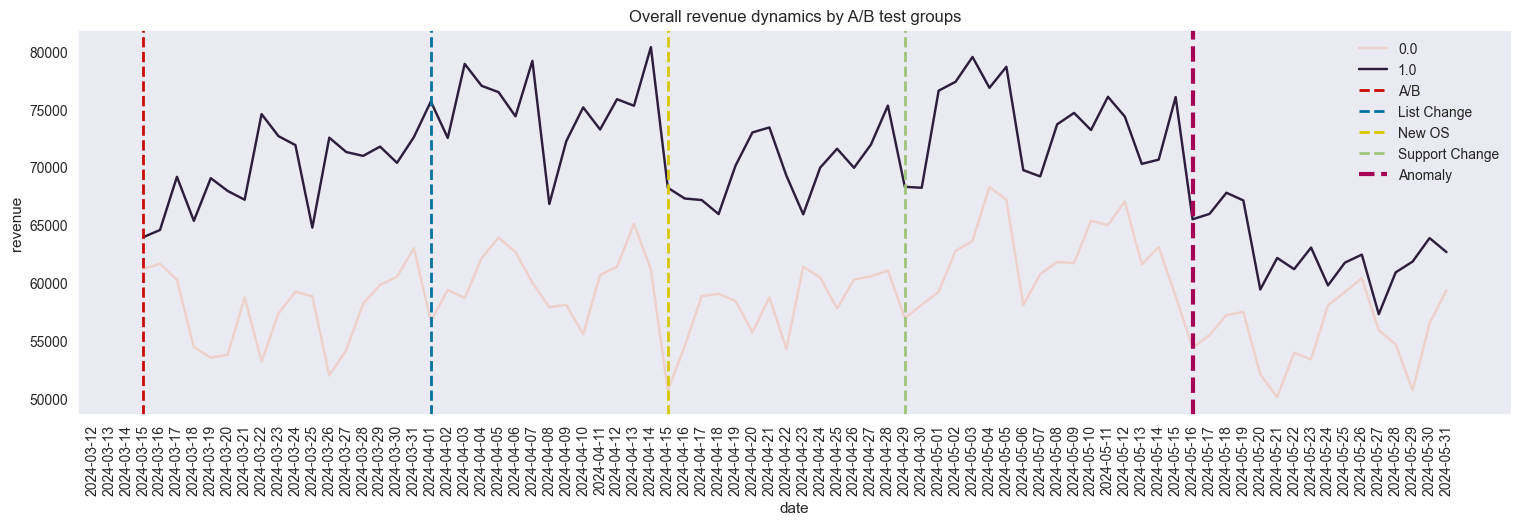

In [47]:
viz('revenue', 'split_group', 'Overall revenue dynamics by A/B test groups')

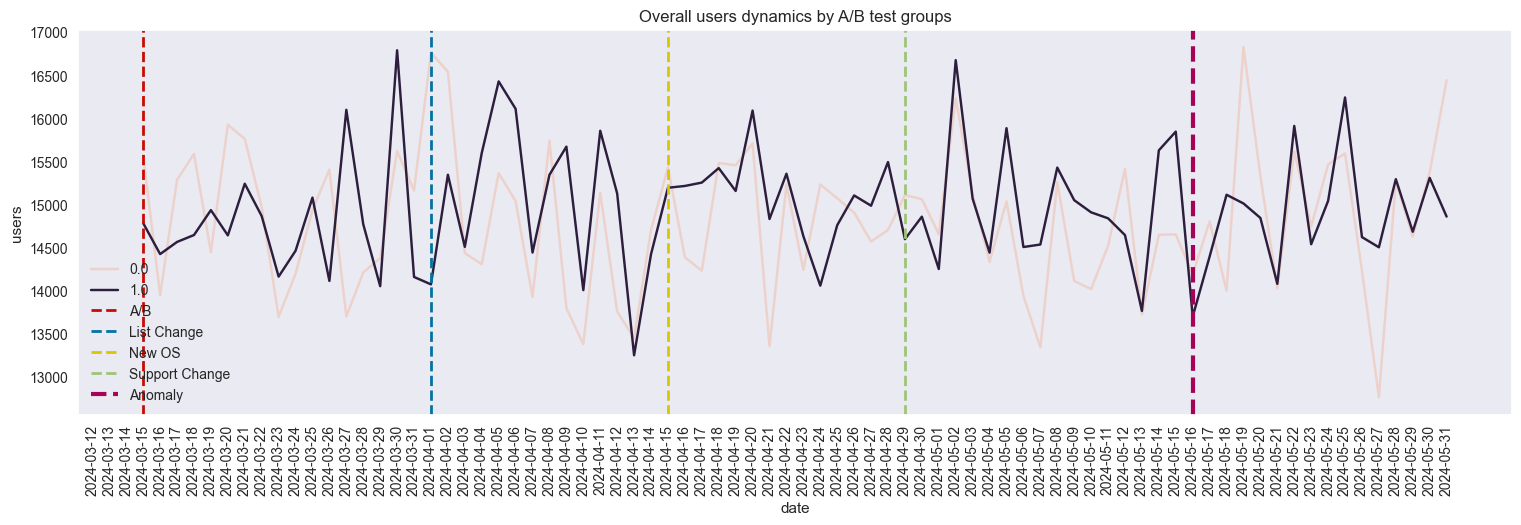

In [48]:
viz('users', 'split_group', 'Overall users dynamics by A/B test groups')

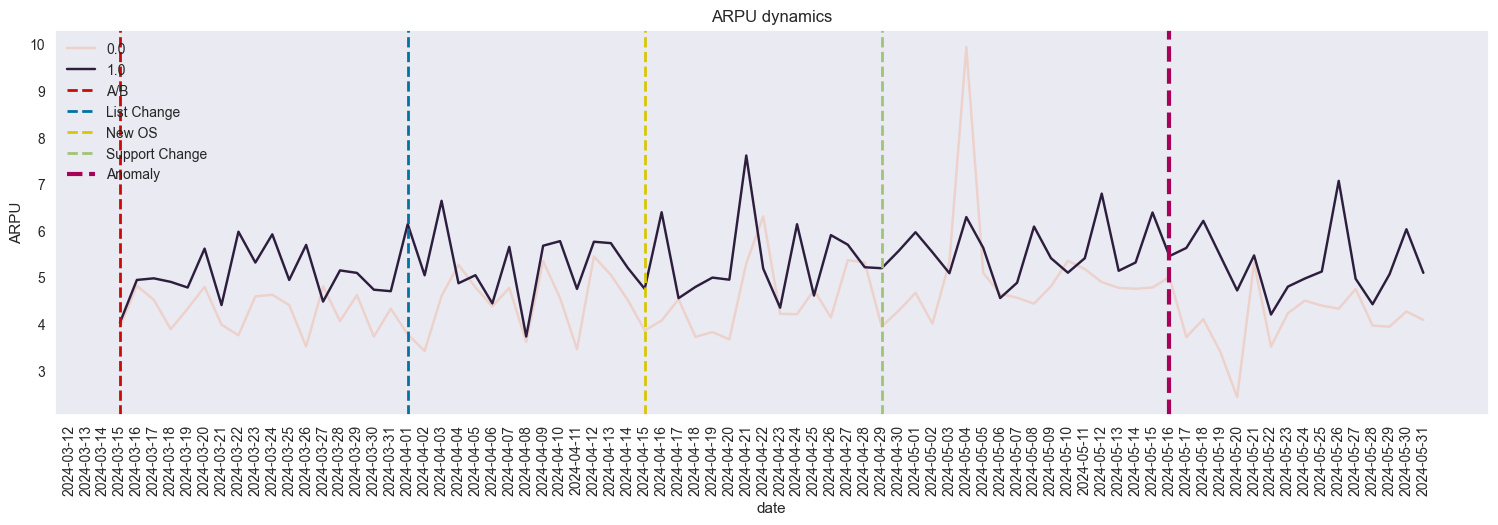

In [49]:
viz('ARPU', 'split_group', 'ARPU dynamics')

### Gender

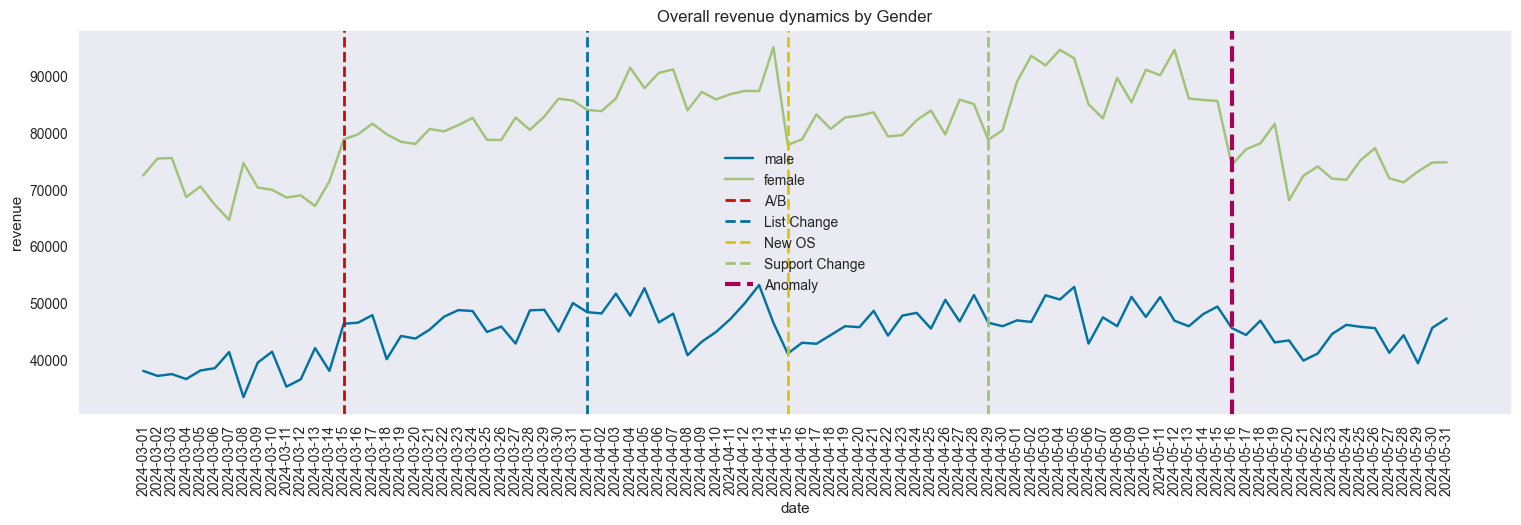

In [50]:
viz('revenue', 'gender', 'Overall revenue dynamics by Gender')

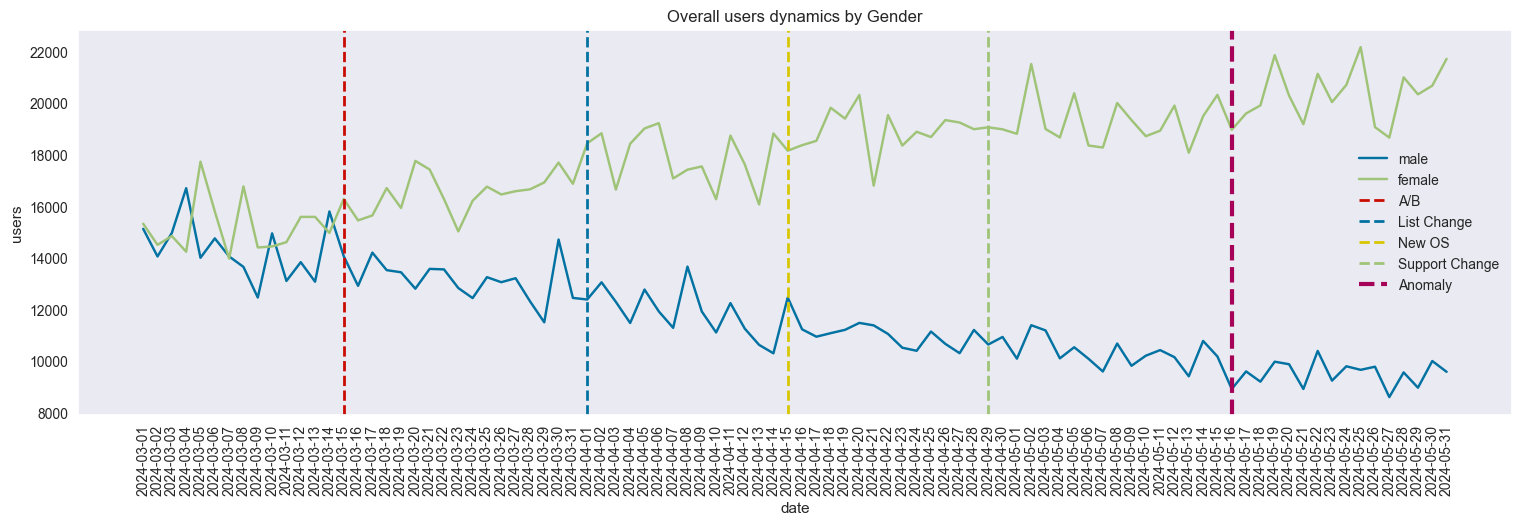

In [51]:
viz('users', 'gender', 'Overall users dynamics by Gender')

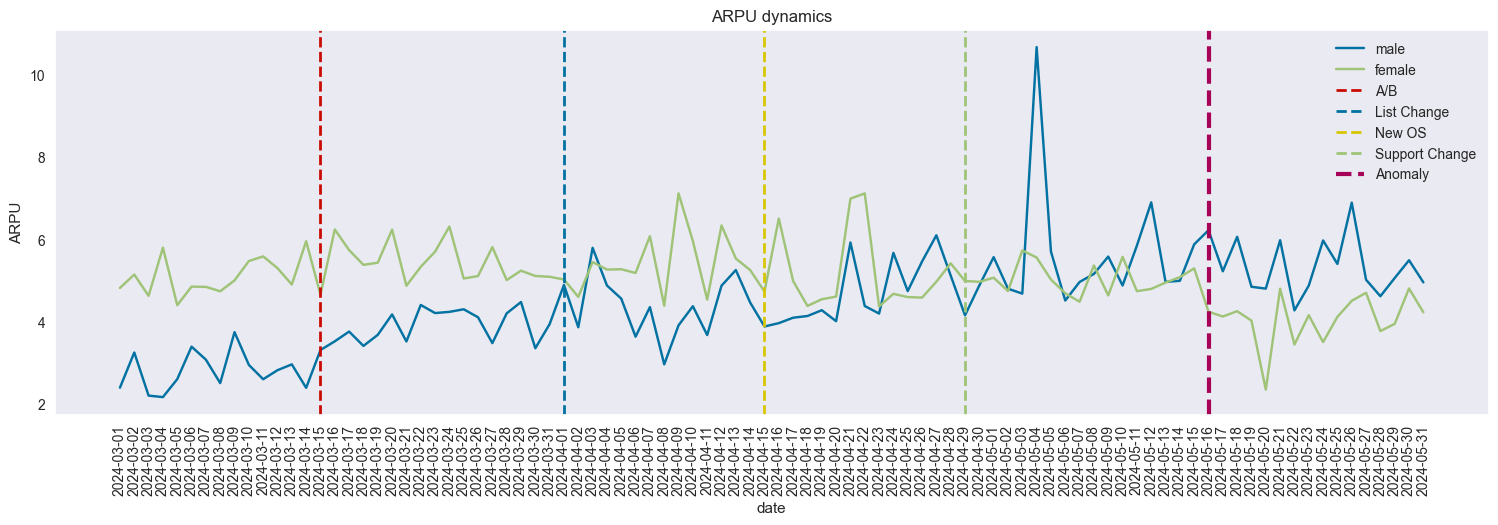

In [52]:
viz('ARPU', 'gender', 'ARPU dynamics')

### OS version

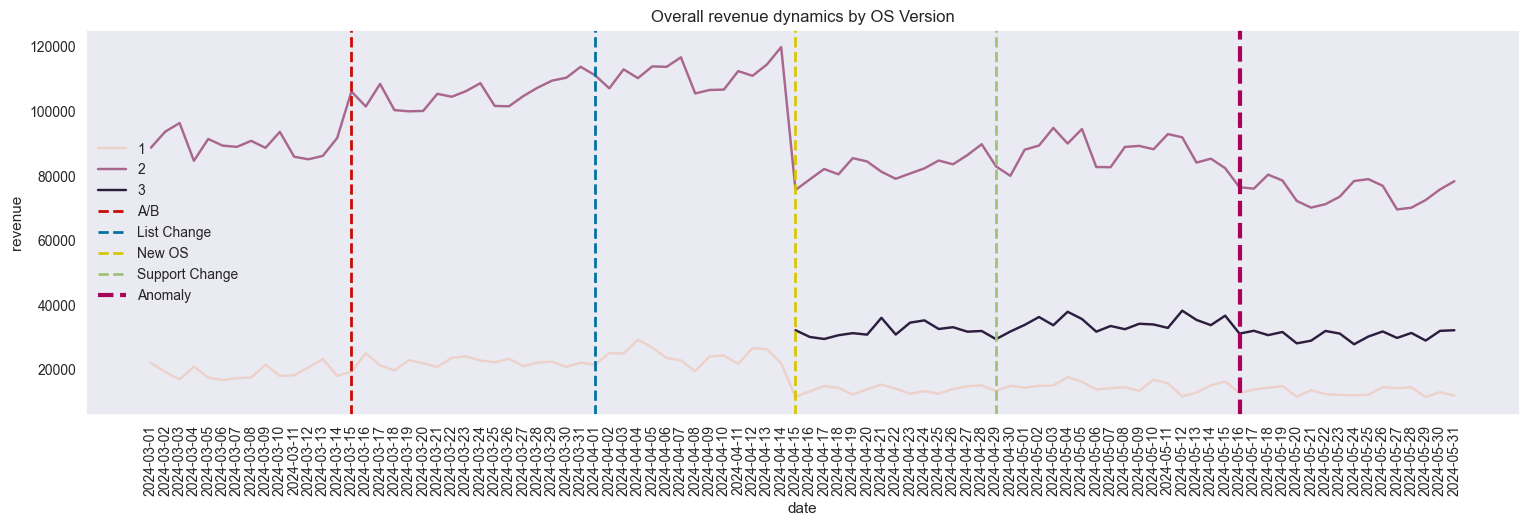

In [53]:
viz('revenue', 'os_version', 'Overall revenue dynamics by OS Version')

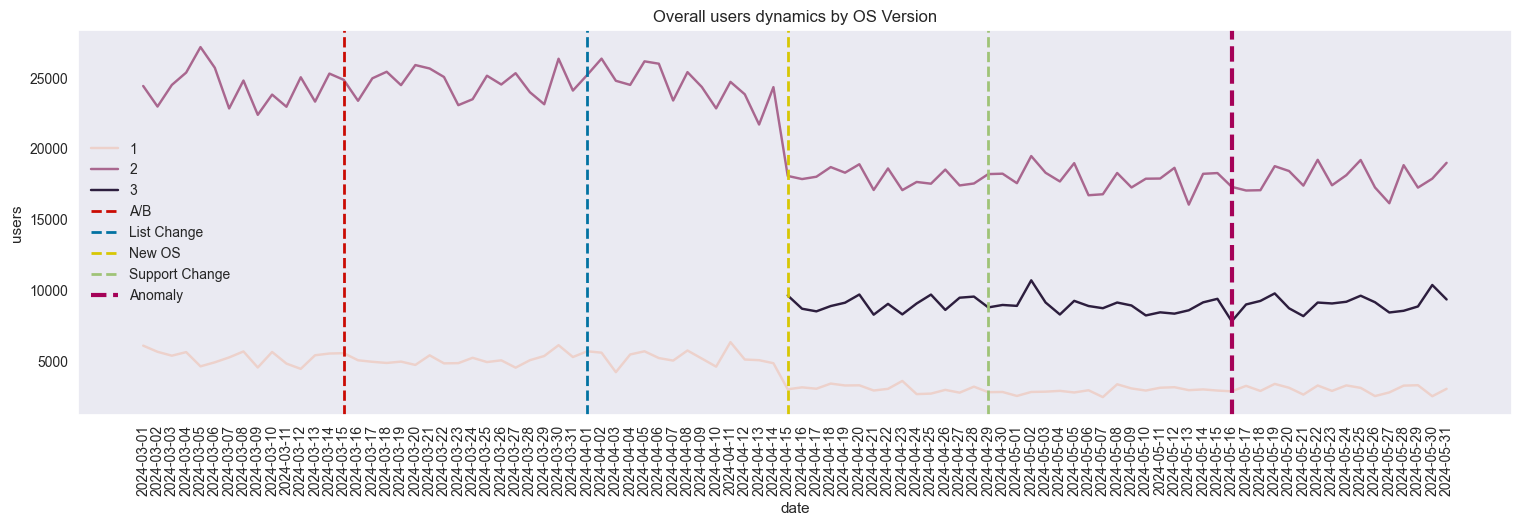

In [54]:
viz('users', 'os_version', 'Overall users dynamics by OS Version')

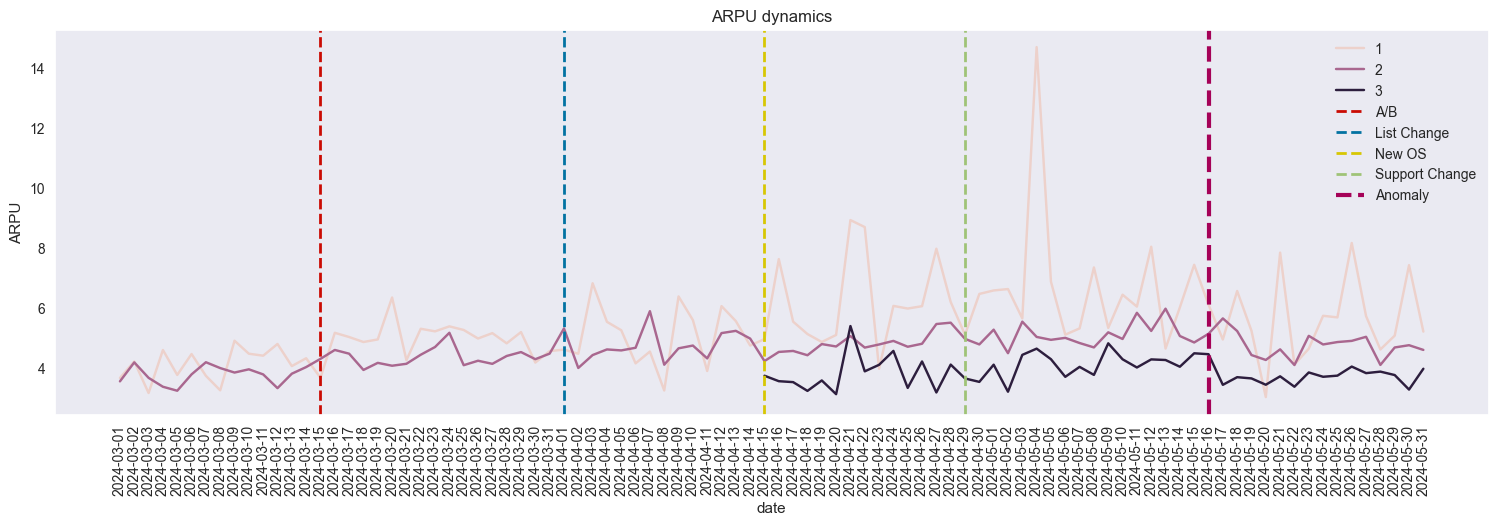

In [55]:
viz('ARPU', 'os_version', 'ARPU dynamics')

### Age Group

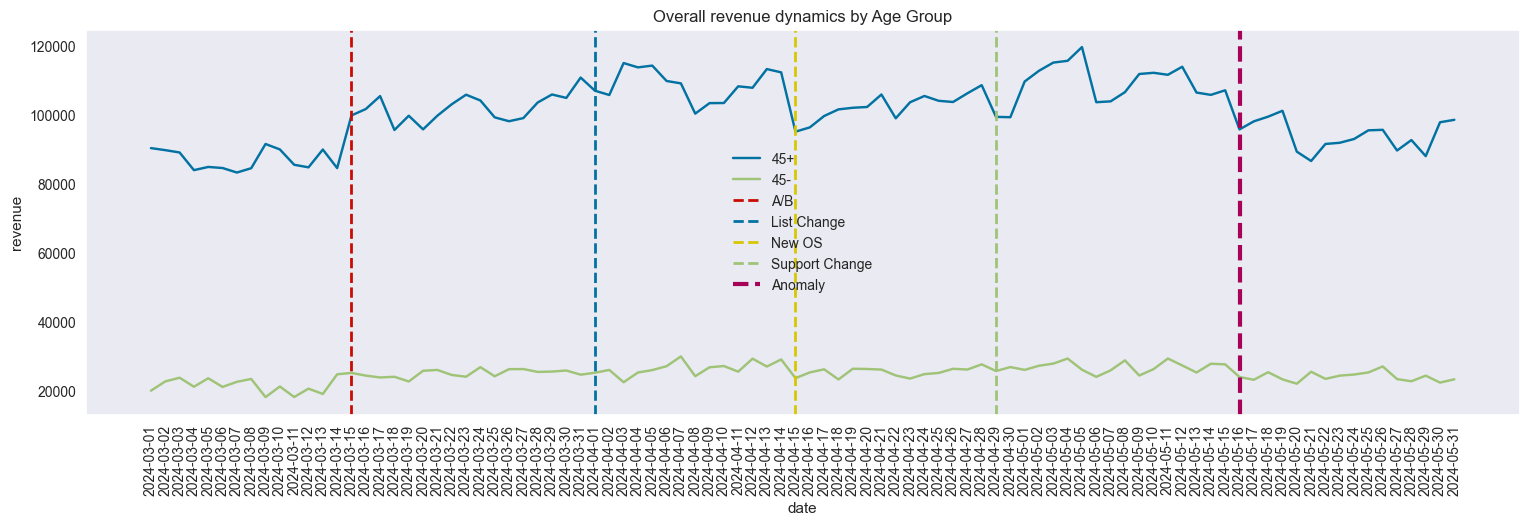

In [56]:
viz('revenue', 'age_group', 'Overall revenue dynamics by Age Group')

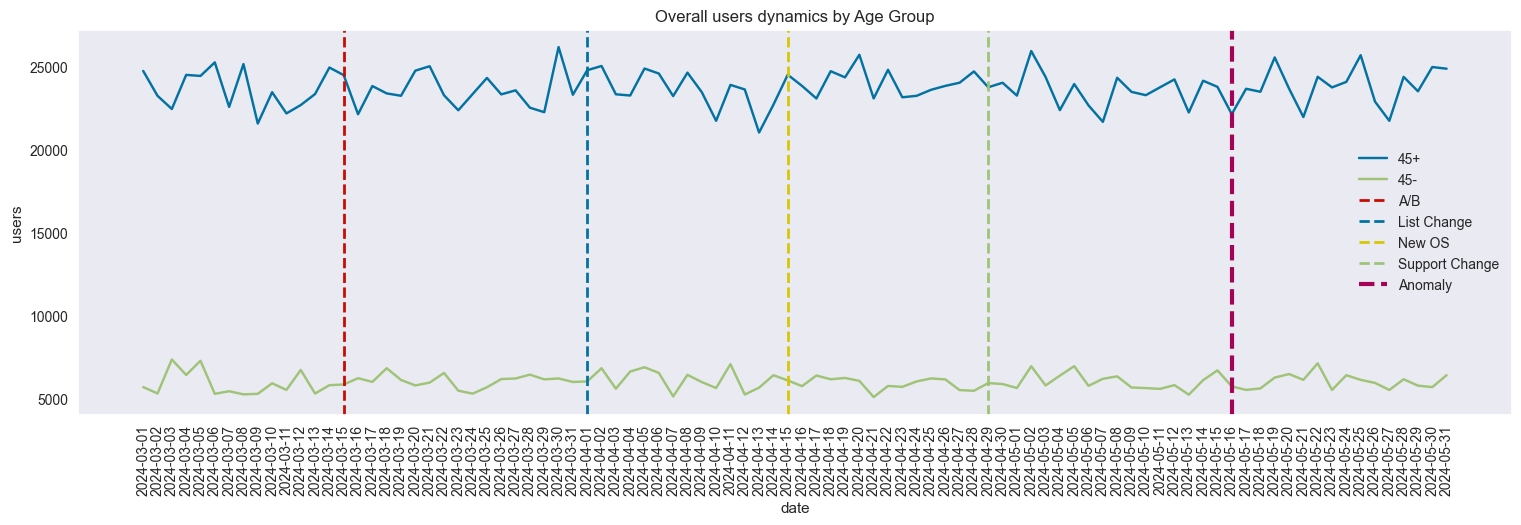

In [57]:
viz('users', 'age_group', 'Overall users dynamics by Age Group')

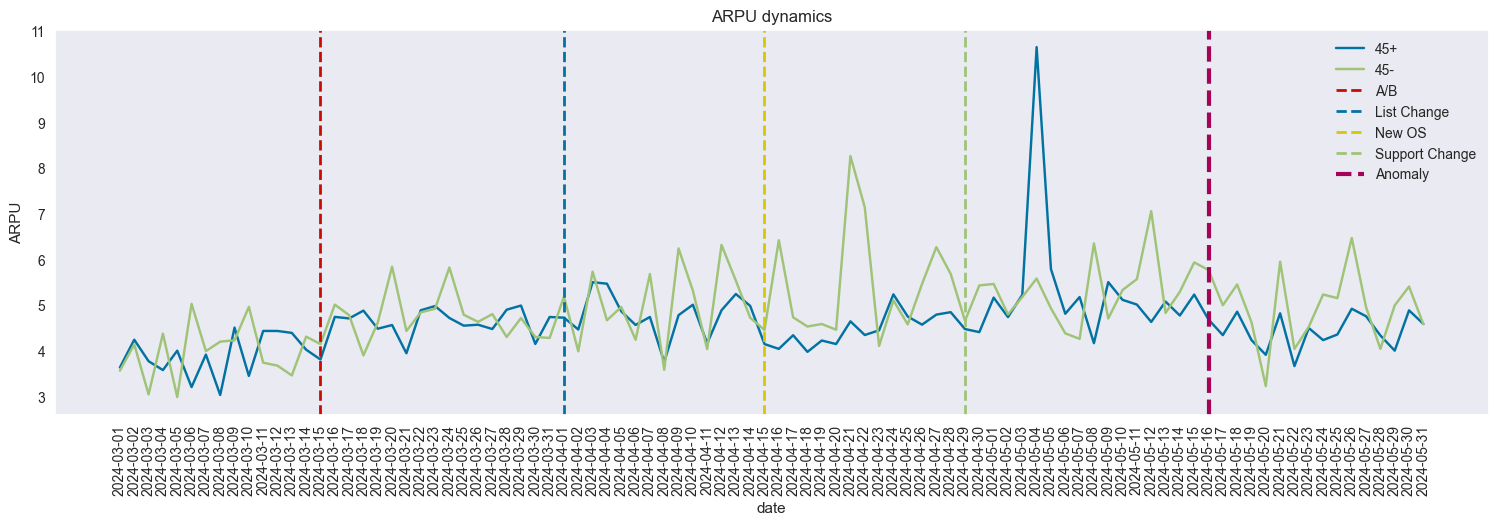

In [58]:
viz('ARPU', 'age_group', 'ARPU dynamics')

### Country Group

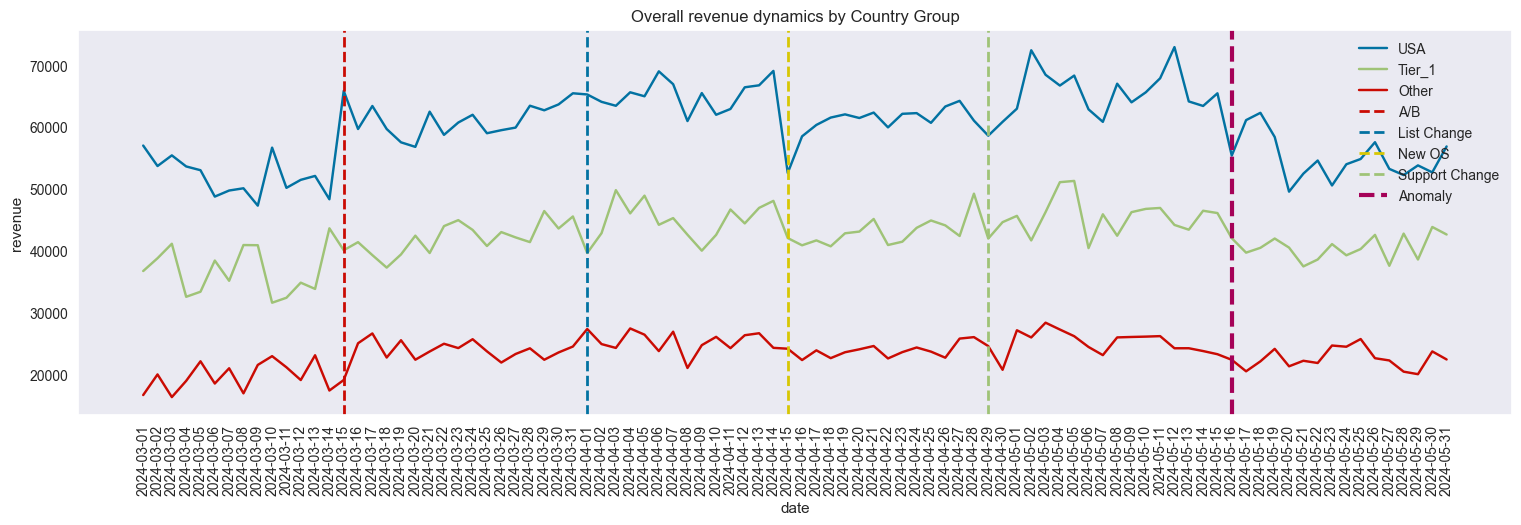

In [59]:
viz('revenue', 'country_group', 'Overall revenue dynamics by Country Group')

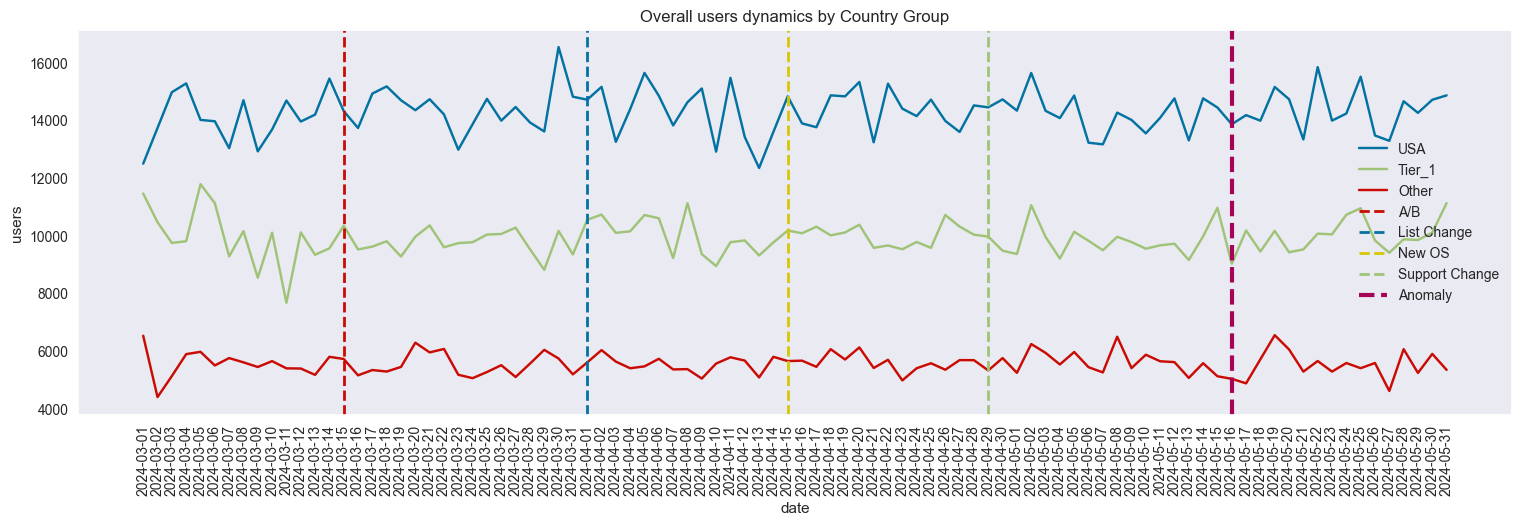

In [60]:
viz('users', 'country_group', 'Overall users dynamics by Country Group')

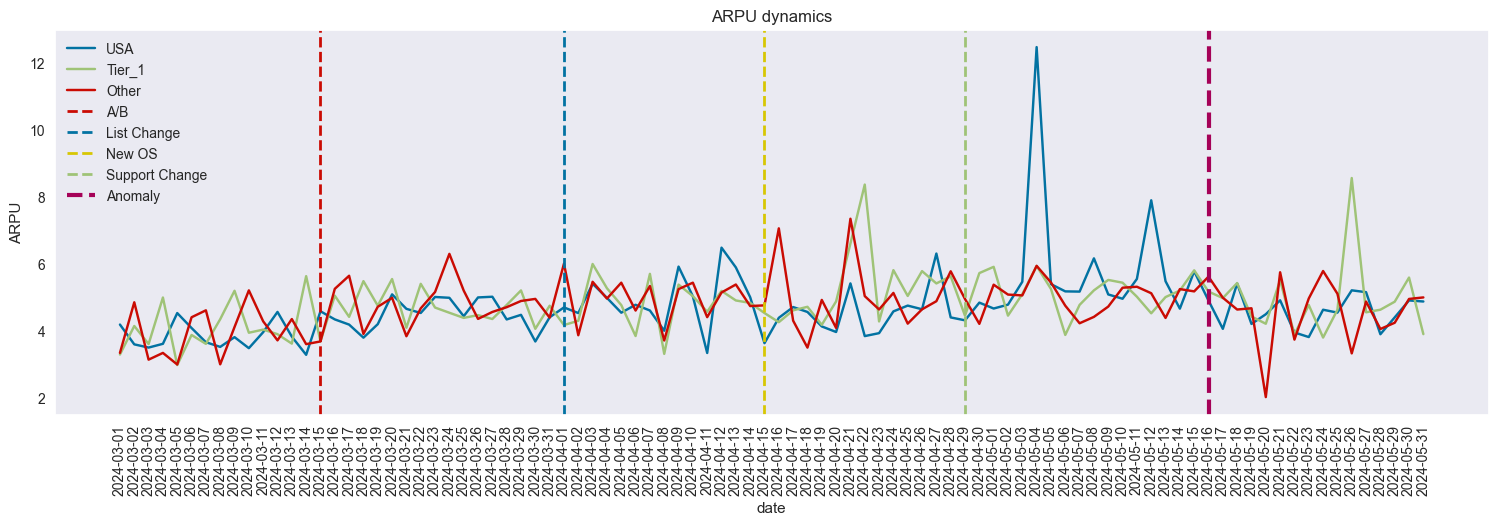

In [61]:
viz('ARPU', 'country_group', 'ARPU dynamics')

### Спостереження

Аналіз до аномалії
 Маємо "2024-05-04" найбільше значення ARPU, але воно поснено тим, що чоловіки 45+ з США, які входять до структури користувачів, які використовують "ОС_1", що має найменше користувачів серед усіх та й кількість чоловіків теж постійно зменшується, 
тому їх більша активність у цей день спровокувала такий зріст. 
 Як анслідок, на цей момент, при подальшому аналізі, я звертати увагу не буду.

Правка:
  Логіку листування та зменшення підтримки враховувати не буду, бо результати сфабриковані сезонністю та й аудиторія не здатна за кілька днів відчути зміни такого типу (тільки протягом певного часу завдяки тенденції), або якщо значну частину трафіку не складають юзери з каналу “email”, що в завданні не також зазначено. 

Загалом:
 1. Виручка: виросла під час А/Б тесту; впала, коли зʼявилася нова OS. 
 2. Аудиторія: взагалі не реагує на події.
 3. ARPU: збільшується після початку  A/B тесту, коли кількість людей в групі адекватна; зменшується після оновлення OS.

А/Б тест:
 1. Виручка: коли зʼявилася нова OS - впала в обох групах. 
 2. Аудиторія: ряд майже стаціонарний для двох груп.
 3. ARPU: зменшується з оновленням ОС.
 4. Структура: більше заробіток у групи 1; за розміром групи однакові; ARPU у 1 групи більше. 

Стать: 
1. Виручка: зросла під час А/Б тесту; впала, коли зʼявилася нова OS.
 2. Аудиторія: чоловіча аудиторія постійно падає, жіноча навпаки.
 3. ARPU: у жінок ARPU спадає, бо їх кількість постійно зростає; ARPU для чоловічої зростає, оскільки витарти стабільні та аудиторія падає. Але після оновлення ОС показник впав для обох груп.
 4. Структура: жінки більше витрачають, аніж чоловіки, але прибуток з чоловіків не спадає; жіноча аудиторія постійно росте, на відміну від чоловічої; жінки витрачають більше на одну особу.

OS:
 1. Виручка: впала для «1» та «2» ОС, після появи 3-го, бо ліквідність перейшла до неї; A/B тест збільшив виручку.
 2. Аудиторія: впала для «1» та «2» ОС, після появи 3-го, бо частина аудиторії перейшла на 3-тю.
 3. ARPU: після проведення A/B тесту збільшився для обох груп; збільшився для 1-го ОС після оновлення і не змінився для 2-го ОС, що вказує на більшу платоспроможність 1-ої групи, але їх кількість найменша.
 4. Структура: у ОС №2 найбільший прибуток, у №3 середній та №1 найменший в сумі; кожен з рядів схожий на стаціонарний (у 2-ої набільше аудиторії, 3-тя замймає впевнену середину, а 1-а займає найменшу частку); ARPU для 2 (найбільший) та 3 (найменший) ОС стаціонарний та дуже активний для 1-го ОС.

Вік:
 1. Виручка: після початку A/B тесту збільшилась; після появи нової ОС спала. 
 2. Аудиторія: не реагує.
 3. ARPU: після A/B тесту збільшився; з оновленням ОС - зменшився й став більш волатильним.
 3. Структура: виручка з "45+" більше, ніж у "45-"; аудиторії в "45+" більше, ніж у "45-"; ARPU однаковий.

Країни: 
 1. Виручка: після початку A/B тесту збільшився; після появи нової ОС спала.
 2. Аудиторія: не реагує. 
 3. ARPU: збільшився після початку A/B тесту; не змінився (але у США зманився), але став більш волатильним після оновлення ОС.
 3. Структура: США більше приносить грошей, Європа також багато, "інші" найменше; 
        США найбільше має користувачів, Європа також багато, "інші" найменше; 
        ARPU +- у всіх однаковий.



Після аномалії:
Загалом:  
 1. Виручка: значно впала.
 2. Аудиторія: стаціонарно.
 3. ARPU: впав.

А/Б: 
 1. Виручка: в тестовій групі впала більш значно, аніж у контрольній, майже вирівнявшись з нею, але проблема аномалії стосується обох.
 2. Аудиторія: стаціонарно;
 3. ARPU: для контрольної групи впав, а для тестової також впав, але не так сильно.

Гендер: 
 1. Виручка: впала більш значно у жінок, ніж у чоловіків.
 2. Аудиторія: у жінок росте, у чоловіків падає.
 3. ARPU: у чоловіків зі зменшенням аудиторії росте, а у жінок навпаки.

ОС: 
 1. Виручка: 2-ий ОС найбільше відчув вплив.
 3. ARPU: впав у всіх групах, але 1 ОС швидко відновився, бо що аудиторія, що прибуток мають однаковий негативний тренд.

Вік: 
 1. Виручка: група «45+» відчула біль значно більше.
 3. ARPU: впав в обох групах, але “45-” поводить більш стабільно.

Країна: 
 1. Виручка: у США впала найбільше.
 3. ARPU: впав для всіх, та велику волатильність можна пояснити кількістю людей в групі.

#### A/B test perfomance

In [184]:
ab_df = df[(df['date']>='2024-03-15') & (df['date']<'2024-05-16')]
ab_df.sample(2)

,date,users,revenue,split_group,gender,os_version,age_group,country_group,ARPU
368,2024-03-15,935,2807.03,0.0,female,2,45+,Other,3.002171
1107,2024-03-31,104,425.60,0.0,male,1,45-,USA,4.092308


In [194]:
# Як ми бачили на графіках вище - активність юзерів в групах майже однакові, тому результати розрахунків будуть правильні.
# тому візьму різницію ARPU (в день) між групами, а потім визначу середню різницю.
A = pd.DataFrame({
    'revenue':ab_df[ab_df['split_group']==0].groupby('date')['revenue'].sum(),
    'users':ab_df[ab_df['split_group']==0].groupby('date')['users'].sum()
})
A['ARPU'] = A['revenue'] / A['users']
A = A.drop(['revenue', 'users'], axis=1)

B = pd.DataFrame({
    'revenue':ab_df[ab_df['split_group']==1].groupby('date')['revenue'].sum(),
    'users':ab_df[ab_df['split_group']==1].groupby('date')['users'].sum()
})
B['ARPU'] = B['revenue'] / B['users']
B = B.drop(['revenue', 'users'], axis=1)

In [206]:
ab = A.merge(B, on='date')
ab['diff'] = ab['ARPU_y'] - ab['ARPU_x']
diff = ab['diff'].mean()
print(f'Середня різниція заробітку з одного юзера в день між групами 1 та 0 складає: {diff:.3f}$')

Середня різниція заробітку з одного юзера в день між групами 1 та 0 складає: 0.777$


In [219]:
def mean(x, y):
    return np.mean(y - x)
  
ci = bootstrap((ab['ARPU_x'], ab['ARPU_y']), 
                    statistic=mean, 
                    vectorized=False, paired=True, 
                    n_resamples=1000, random_state=9603)

print(f'У 95% випадків різниця між APRU цих двох груп становить від {ci.confidence_interval[0]:.3f}$ до {ci.confidence_interval[1]:.3f}$.')

У 95% випадків різниця між APRU цих двох груп становить від 0.679$ до 0.878$.


### Висновок

In [ ]:
Найвпливовіші фактори:
Виходить з усього цього, що "Оновлення ОС" та "спліт-тест" мають найбільший вплив на виручку. 
  1. З появою нового ОС утворился група людей (ОС 3), які менше на одну особу приносять грошей, але ARPU для ОС 1 став більше.
  2. A/B тест позитивно вплинув на виручку, даючи розуміння того, що новий функціонал необхідний для приросту прибутку.
    І в середньому, в день ARPU більше на ~0.78$ у тестовій групі.
  3. Сезонність, бо деякі ефекти, які спостерігались, були не через їх силу, а через сезонність динаміки придбань.

## Дослідження сезонності

### Візуалізації

In [28]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

In [69]:
df_s = df.groupby('date').revenue.sum()
df_s.head()

date
2024-03-01    110486.59
2024-03-02    112579.29
2024-03-03    112977.09
2024-03-04    105240.24
2024-03-05    108615.19
Name: revenue, dtype: float64

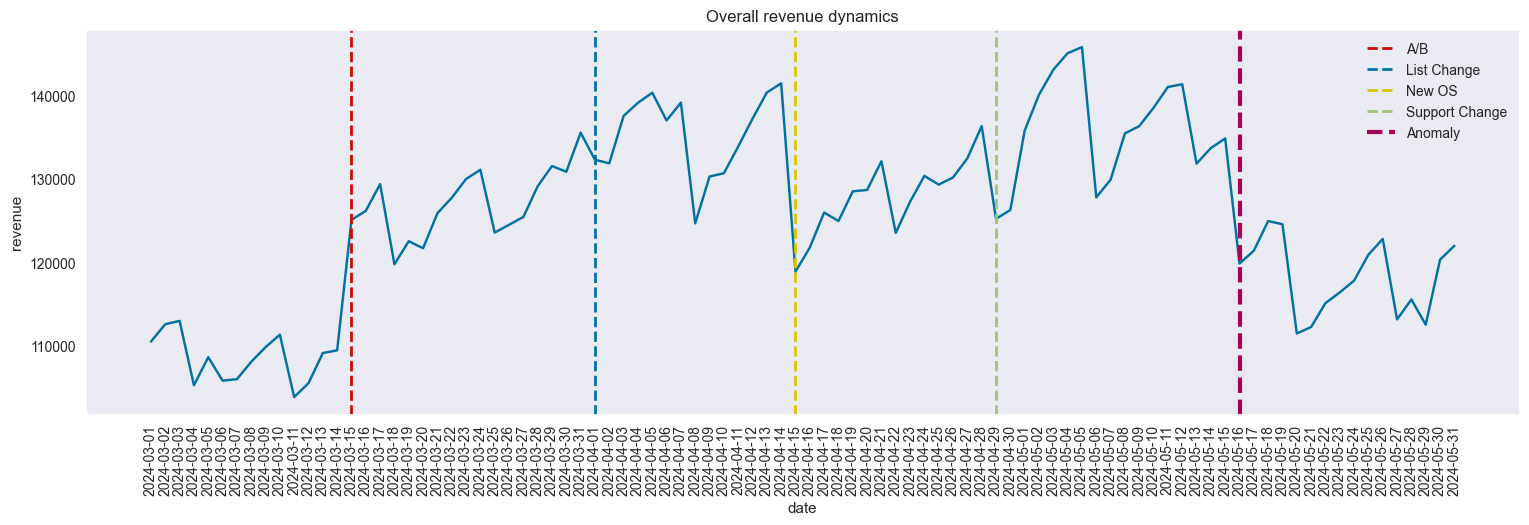

In [36]:
viz('revenue', None, 'Overall revenue dynamics')
# Циклічність на графіку присутня.

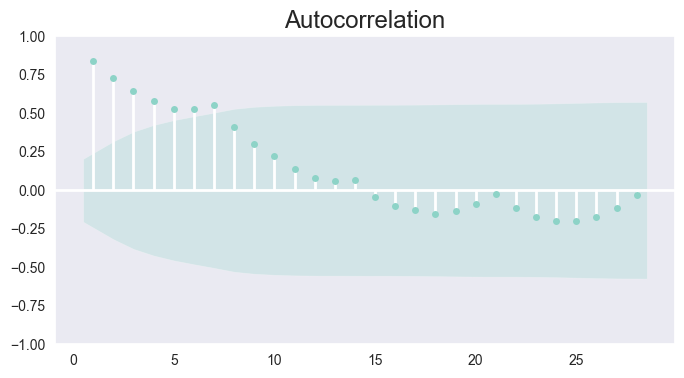

In [70]:
# Зображаю ACF для знаходження сезонності по днях.
# Сутність роботи цього методу полягає в тому, що за наявності сезонності в даних (у даному прикладі по днях)
# то кожні n періодів після спаду буде висвітлюватись новий умовний пік. 
# На графіку бачимо, що кожні 7 така тенденція має місце.
fig, (ax1) = plt.subplots(1,1,figsize=(8,4))
plot_acf(df_s,
        lags=28,
        zero=False,
        ax=ax1)
plt.show()
# Маємо тижневу сезонність зі значущими затримками до семи днів. 
# Далі можемо спосерігати теж сезонність й позитивану та негативну автокореляція, яка є невпливовою.

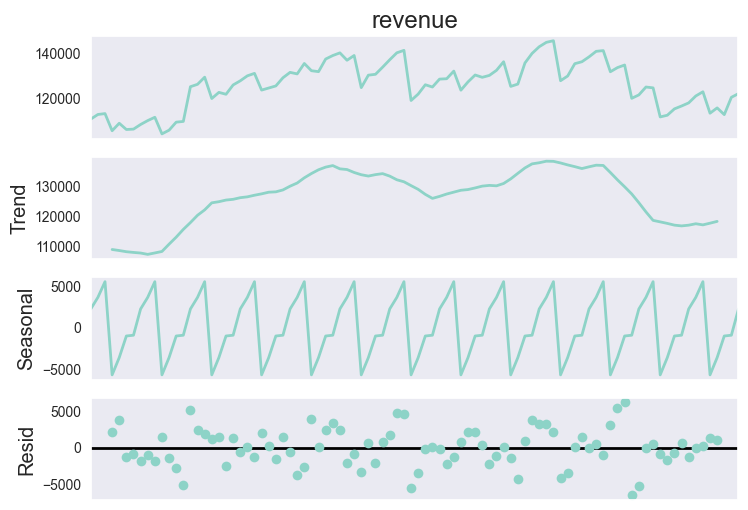

In [91]:
# Щотижнева сезонність
decomp = seasonal_decompose(df_s,
                            period=7)
decomp.plot()
plt.xticks([])
plt.show()
# Тренд був позитивним до аномалії й сезонність справді складає 7 днів.

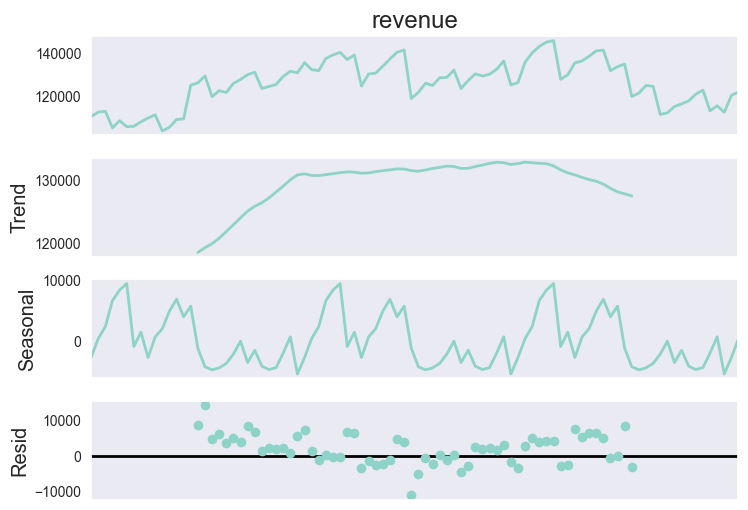

In [93]:
# Вивчаю щомісячну сезонність
decomp = seasonal_decompose(df_s,
                            period=30)
decomp.plot()
plt.xticks([])
plt.show()

### Висновок

Люди витрачають більше під кінець тижня.
    Аудиторія менше витрачає під кінець місяця.

## Оцінка збитків

### Робота над моделлю

In [ ]:
# новий датафрейм для кращого пояснення моделі
df_infl = df.copy()

# Визначаю різні події, які настали 
df_infl['A/B'] = np.where(df_infl['date']>'2024-03-15', 1, 0)
df_infl['List_Change'] = np.where(df_infl['date']>'2024-04-01', 1, 0)
df_infl['New_OS'] = np.where(df_infl['date']>'2024-04-15', 1, 0)
df_infl['Support_Change'] = np.where(df_infl['date']>'2024-04-29', 1, 0)
df_infl['Anomaly'] = np.where(df_infl['date']>'2024-05-16', 1, 0)

In [26]:
# Змінюю тип даних.
df_ml = df_infl.copy()
df_ml['split_group'] = df_ml['split_group'].fillna(2)
df_ml['date'] = pd.to_datetime(df_ml['date'])
df_ml['split_group'] = df_ml['split_group'].astype('category')
df_ml['os_version'] = df_ml['os_version'].astype('category')
df_ml['country_group'] = df_ml['country_group'].astype('category')
df_ml['sex_age'] = df_ml['gender'].astype('string') + '_' + df_ml['age_group'].astype('string')
df_ml['sex_age'] = df_ml['sex_age'].astype('category')

In [27]:
# Сторюю нові ознаки.
df_ml['day_of_week'] = df_ml['date'].dt.day_name()
df_ml['day'] = df_ml['date'].dt.day
df_ml.sample()

,date,users,revenue,split_group,gender,os_version,age_group,country_group,ARPU,A/B,List_Change,New_OS,Support_Change,Anomaly,sex_age,day_of_week,day
4733,2024-05-25,139,649.64,1.0,male,2,45-,Other,4.673669,1,1,1,1,1,male_45-,Saturday,25


In [28]:
# Розділяю на тестову та трейн датасети (до аномалії та після) для оцінки потенційних збитків.
train = df_ml[(df_ml['date']<'2024-05-16')]
test = df_ml[df_ml['date']>='2024-05-16']

train.sample(3)

,date,users,revenue,split_group,gender,os_version,age_group,country_group,ARPU,A/B,List_Change,New_OS,Support_Change,Anomaly,sex_age,day_of_week,day
3464,2024-05-07,110,538.74,1.0,female,1,45+,Other,4.897636,1,1,1,1,0,female_45+,Tuesday,7
222,2024-03-10,4777,14405.39,2.0,male,2,45+,USA,3.015573,0,0,0,0,0,male_45+,Sunday,10
2519,2024-04-24,177,709.64,0.0,female,2,45-,Other,4.009266,1,1,1,0,0,female_45-,Wednesday,24


In [ ]:
# Налаштовую модель
# Не включав останні дві неділі, бо модель призначена для прогнозування прибутку за відсутності аномалії.
reg_setup = reg.setup(
                data=train,
                target='revenue',
                numeric_features=['day', 'users'],
                ignore_features=['date', 'gender', 'age_group', "ARPU"],
                categorical_features=['split_group', 'os_version', 'country_group', 'sex_age'],
                ordinal_features = {'day_of_week' : ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']},
                preprocess=True,
                use_gpu=True,
                n_jobs=-1,
                session_id=9540,
                fold_shuffle=True,
                fold=5
                )

In [30]:
reg.compare_models(turbo=True, exclude=['catboost'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,442.1601,500059.9007,706.2387,0.9493,0.3992,0.3574,0.3000
lightgbm,Light Gradient Boosting Machine,449.6628,548656.7668,739.7628,0.9442,0.3996,0.3716,0.8580
gbr,Gradient Boosting Regressor,476.0697,606362.7502,776.5150,0.9385,0.4197,0.3965,0.3160
rf,Random Forest Regressor,481.1612,614219.5515,782.3301,0.9375,0.4226,0.3955,0.7360
xgboost,Extreme Gradient Boosting,486.1688,654925.1062,806.7983,0.9336,0.4225,0.3888,0.5560
ada,AdaBoost Regressor,763.5485,1069708.4558,1030.4523,0.8922,0.8547,1.4445,0.1560
lasso,Lasso Regression,654.7692,1101334.1134,1048.0986,0.8880,0.7941,0.7120,0.1200
llar,Lasso Least Angle Regression,654.7693,1101334.2888,1048.0987,0.8880,0.7941,0.7120,0.1060
br,Bayesian Ridge,652.6632,1101805.8523,1048.3199,0.8880,0.7826,0.7044,0.1180
ridge,Ridge Regression,656.8031,1102768.6497,1048.7942,0.8879,0.7916,0.7206,0.0960


ExtraTreesRegressor(n_jobs=-1, random_state=9540)

In [31]:
# Обираю одну з найкращих оделей
model = reg.create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,474.3859,617260.7103,785.6594,0.9381,0.3944,0.3516
1,425.8075,497712.5257,705.4874,0.9384,0.3980,0.3662
2,422.2125,496636.4957,704.7244,0.9514,0.4004,0.3643
3,449.9719,520544.9252,721.4880,0.9495,0.3928,0.4011
4,476.0099,615817.8789,784.7406,0.9431,0.4128,0.3750
Mean,449.6776,549594.5072,740.4200,0.9441,0.3997,0.3716
Std,22.9264,55325.2550,37.0508,0.0055,0.0071,0.0165


### Робота над оцінкою

In [143]:
# Оскільки відбулася аномалія - модель не здатна дуже добре прогнозувати саме такі відхилення в прибуках.
# Тому вона знадобиться для розрахунку значень "revenue" за умов, якщо б не було аномалії для оцінки збитків.
reg_pred = reg.predict_model(model, test)
reg_pred['diff'] = reg_pred['prediction_label'] - reg_pred['revenue']
reg_pred.sample(5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,448.6099,901772.8627,949.6172,0.7539,0.4924,0.5836


,date,users,split_group,gender,os_version,age_group,country_group,day_of_week,day,revenue,prediction_label,diff
4981,2024-05-28,1717,1.0,female,2,45+,Tier_1,Tuesday,28,7175.919922,8700.686369,1524.766447
4428,2024-05-21,412,0.0,male,3,45+,USA,Tuesday,21,1894.270020,1746.950895,-147.319125
5129,2024-05-30,213,1.0,female,2,45-,Other,Thursday,30,1342.329956,1319.014355,-23.315601
4605,2024-05-23,511,0.0,female,2,45-,USA,Thursday,23,2520.379883,2361.634746,-158.745137
4173,2024-05-17,598,0.0,female,2,45-,USA,Friday,17,1629.300049,2625.994664,996.694615


<Axes: xlabel='date', ylabel='revenue'>

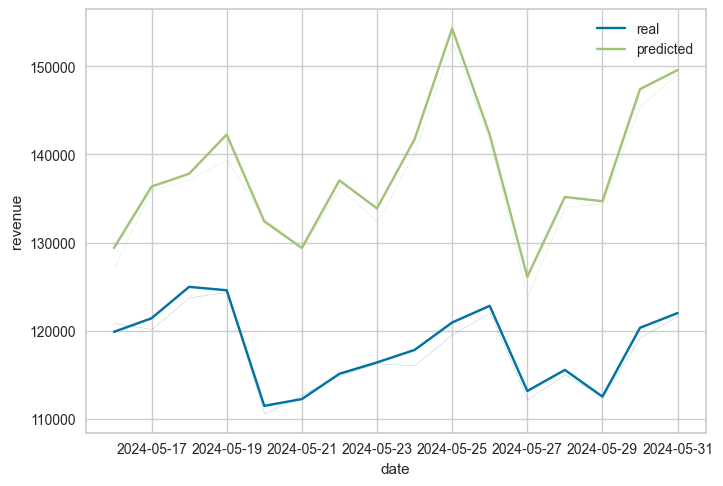

In [144]:
# Динаміка прибутку за умови реальних подій й без аномалії.
fig, ax = plt.subplots()
sns.lineplot(
    data=reg_pred,
    x='date',
    y='revenue',
    ax=ax,
    ci=False,
    estimator='sum',
    label='real')

sns.lineplot(
    data=reg_pred,
    x='date',
    y='prediction_label',
    ax=ax,
    ci=False,
    estimator='sum',
    label='predicted')

In [146]:
# Для того, щоб оцінити значення збитків
df_un = reg_pred.groupby('date', as_index=False)['diff'].sum()
df_un['day'] = df_un['date'].dt.day
df_un

,date,diff,day
0,2024-05-16,9521.679245,16
1,2024-05-17,14942.549425,17
2,2024-05-18,12833.146879,18
3,2024-05-19,17666.880924,19
4,2024-05-20,20936.173262,20
5,2024-05-21,17151.825005,21
6,2024-05-22,21938.347338,22
7,2024-05-23,17472.525170,23
8,2024-05-24,23901.114017,24
9,2024-05-25,33364.022463,25


In [147]:
# Лінійна регресія для пррогнозу збитків.
losses_un = sm.OLS(df_un['diff'], df_un['day']).fit()

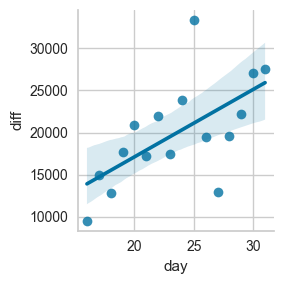

In [154]:
# Тренд збитків за осатнні 2 тижні.
sns.lmplot(
    data=df_un,
    x='day',
    y='diff',
    height=3
)

In [155]:
# Я припускаю, що з проблемуою будуть боротися приблизно тиждень,
# тому використав лінійну регреісю для оцінки збитків на наступні 7 днів.
pred_df = pd.DataFrame({'date':pd.date_range('2024-06-01', periods=7, freq='D'),
                         'day':np.arange(32,39,1)})
pred_df = pred_df.assign(
    losses = losses_un.predict(pred_df['day'])
)
pred_df

,date,day,losses
0,2024-06-01,32,27057.479146
1,2024-06-02,33,27903.025369
2,2024-06-03,34,28748.571593
3,2024-06-04,35,29594.117816
4,2024-06-05,36,30439.664039
5,2024-06-06,37,31285.210263
6,2024-06-07,38,32130.756486


### Висновок

In [159]:
# Загальні збитки
losses = df_un['diff'].sum() + pred_df['losses'].sum()
print(f'Загальні збитки на даний момент складають: {df_un["diff"].sum():.2f}$.\n Загальні прогнозовані збитки: {losses:.2f}$.')

Загальні збитки на даний момент складають: 318560.11$.
 Загальні прогнозовані збитки: 525718.93$.


## Визначення цільової аудиторії

In [98]:
del df_ml['sex_age']
df_ml['char'] = df_ml['gender'].astype('string') + '_' + df_ml['age_group'].astype('string') + '_' + df_ml['country_group'].astype('string') + '_' + df_ml['os_version'].astype('string') + 'OS'
df_ml['char'] = df_ml['char'].astype('category')

In [99]:
train = df_ml[(df_ml['date']<'2024-05-16')]

In [ ]:
# Налаштовую модель
# Не включав дві останні неділі, бо й так зрозуміло, що аномалія має ведикий вплив.
reg_setup = reg.setup(
                data=train,
                target='revenue',
                numeric_features=['day'],
                ignore_features=['date', 'ARPU', 'users', 'gender', 'age_group', 'os_version', 'country_group', 'split_group',
                                'A/B', 'List_Change', 'New_OS', 'Support_Change', 'Anomaly'],
                categorical_features=['char'],
                ordinal_features = {'day_of_week' : ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']},
                preprocess=True,
                use_gpu=True,
                n_jobs=-1,
                session_id=9540,
                fold_shuffle=True,
                fold=5,
                max_encoding_ohe=40
                )

In [120]:
reg.compare_models(turbo=True, exclude=['catboost'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,585.7958,1127568.8496,1055.2272,0.8869,0.6095,0.5214,1.1960
br,Bayesian Ridge,634.7392,1348770.7597,1152.8931,0.8649,0.6365,0.5519,0.0680
ridge,Ridge Regression,633.1663,1349522.6658,1153.0729,0.8649,0.6106,0.5618,0.0760
lr,Linear Regression,635.2650,1348969.5861,1153.0138,0.8649,0.6245,0.5501,0.0740
lar,Least Angle Regression,635.2580,1348953.6096,1153.0076,0.8649,0.6247,0.5500,0.0900
lasso,Lasso Regression,634.5481,1349802.5526,1153.3587,0.8648,0.6103,0.5629,0.0700
llar,Lasso Least Angle Regression,634.5507,1349798.1661,1153.3591,0.8648,0.6108,0.5630,0.0860
xgboost,Extreme Gradient Boosting,634.4536,1378167.6000,1168.5147,0.8614,0.5504,0.4857,0.4740
gbr,Gradient Boosting Regressor,729.0857,1470692.7231,1206.0412,0.8524,0.7024,0.9408,0.2140
huber,Huber Regressor,598.6130,1481357.5003,1206.1255,0.8516,0.4737,0.4108,0.1440


LGBMRegressor(device='gpu', n_jobs=-1, random_state=9540)

In [121]:
# Обираю одну з найкращих моделей
model = reg.create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,576.6955,930083.5044,964.4084,0.9068,0.6237,0.5060
1,514.9794,770061.1493,877.5313,0.9047,0.5329,0.4600
2,615.0811,1423843.6284,1193.2492,0.8608,0.5691,0.4729
3,606.8014,1171100.1597,1082.1738,0.8864,0.6470,0.6770
4,615.4216,1342755.8108,1158.7734,0.8760,0.6749,0.4914
Mean,585.7958,1127568.8505,1055.2272,0.8869,0.6095,0.5214
Std,38.1427,246085.9058,118.5933,0.0174,0.0517,0.0793


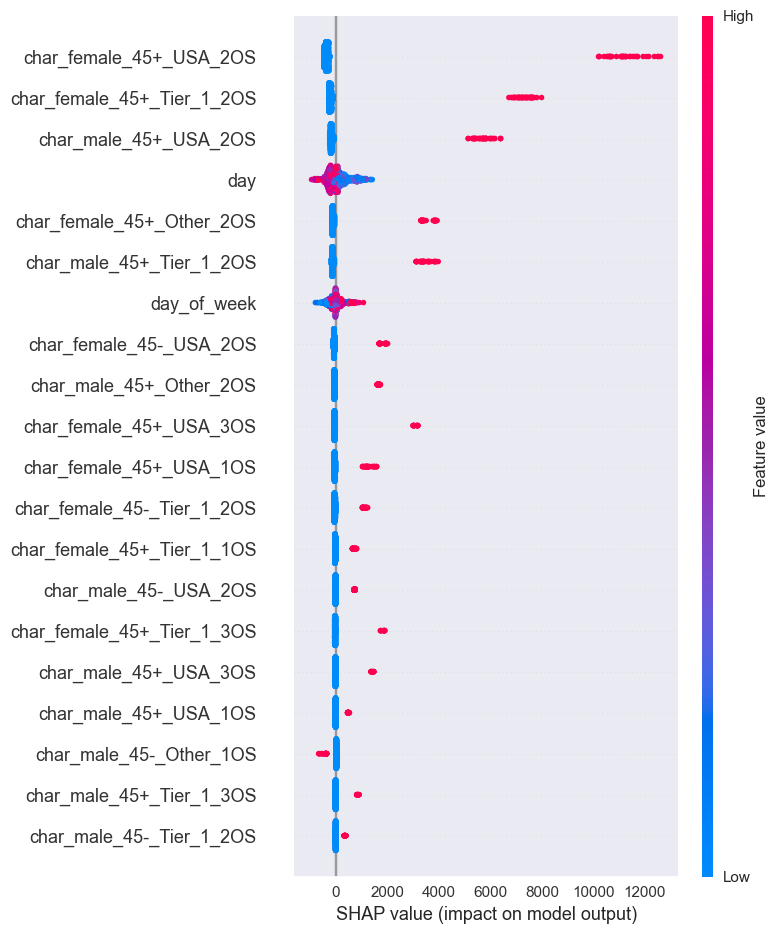

In [122]:
# Шукаю цільові групи.
reg.interpret_model(model)

### Висновок

Цільова аудиторія:
    Жінки та чоловіки 45+ з США, Tier 1 держав, а також жінки 45+ з інших країн, які використовують гаджети з OS №2.

Сезонність:
    Як я зазначав вище - люди більш схильні купляти під кінець тижня, та у першій половині місяця.

## Загальний Висновок

Найбільші фактори впливу на прибуток:
 1. Оновлення ОС.
 2. Спліт тест. Тестова група покращила значення ARPU в день в середьому на ~0.78$, з 95% CI від 0.679$ до 0.878$.
 3. Сезонність.

Сезонність:
    Люди більш схильні купляти під кінець тижня та у першій половині місяця.
    
Оцінка збитків:
  Загальні збитки на даний момент складають: 318560.11 доларів.
  Загальні прогнозовані збитки (якщо ще одну неділю буде аномалія): 525718.93 доларів.
    
Цільова аудиторія:
    Жінки та чоловіки "45+" з США та Tier 1 держав, які мають гаджет з OS №2.